In [1]:
colors = ['binary', 'gist_yarg', 'gist_gray', 'bone', 'pink',
            'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
            'hot', 'afmhot', 'gist_heat', 'copper', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn','PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']

In [2]:
colors = ['Purples','Blues','Greens','Oranges', 'Reds','cool_r','cool','Wistia','Pastel1', 'Pastel2', 'Paired', 'Accent',
                        'Dark2', 'Set1', 'Set2', 'Set3',
                        'tab10', 'tab20', 'tab20b', 'tab20c','Purples','Blues','Greens','Oranges', 'Reds','cool_r','cool','Wistia','Pastel1', 'Pastel2', 'Paired', 'Accent',
                        'Dark2', 'Set1', 'Set2', 'Set3',
                        'tab10', 'tab20', 'tab20b', 'tab20c','Purples','Blues','Greens','Oranges']

In [3]:
len(colors)

44

In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
from skimage import io, transform
import matplotlib.image as mpimg
from PIL import Image
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import scipy
import random
import pickle
import scipy.io as sio

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.ion()

from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from skimage import io
import torch
from torchvision import transforms
import torchvision
from skimage import color
from torch.optim import lr_scheduler
from torchvision.utils import make_grid
import nibabel

In [5]:
import pickle
def pickling(file,path):
    pickle.dump(file,open(path,'wb'))
def unpickling(path):
    file_return=pickle.load(open(path,'rb'))
    return file_return

In [6]:
%matplotlib inline
def show(img):
    
    npimg = img.numpy()
    #print(npimg.shape)
    plt.figure(figsize = (20,20))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()

In [7]:
available_segments = [  0,   2,   3,   4,   5,   7,   8,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  24,  26,  28,  30,  31,  41,  42,  43,  44,  46,
        47,  49,  50,  51,  52,  53,  54,  58,  60,  62,  63,  72, 
        85, 251, 252, 253, 254, 255]

In [8]:
class BrainImages(Dataset):
    def __init__(self, image_dir, label_dir, train_data = False, flipping = True, rotation = True, translation = True):
        
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.flipping = flipping
        self.rotation = rotation
        self.translation = translation
        self.train_data = train_data

    def __len__(self):
        return len(self.image_dir)

    def __getitem__(self,idx):
        image_path = "/gpfs/data" + self.image_dir[idx]
        aseg_path = "/gpfs/data" + self.label_dir[idx]
        
        img_orig = nibabel.freesurfer.mghformat.MGHImage.from_filename(image_path)
        image = img_orig.get_data().astype(np.float64)
        aseg_img = nibabel.freesurfer.mghformat.MGHImage.from_filename(aseg_path)
        aseg_img = aseg_img.get_data().astype(np.float64)
        
        flip = random.random() > 0.5
        angle = random.uniform(-5,5)
        dx = np.round(random.uniform(-10,10))
        dy = np.round(random.uniform(-10,10))
        
        im = Image.fromarray(image[0])
        target = Image.fromarray(aseg_img[0])
        if self.train_data:
            if self.flipping and flip:
                im = im.transpose(0)
                target = target.transpose(0)
            if self.rotation:
                im = im.rotate(angle)
                target = target.rotate(angle)
            if self.translation:
                im = im.transform((256,256),0, (1,0,dx,0,1,dy))
                target = target.transform((256,256),0,(1,0,dx,0,1,dy))
        
#        im = torch.from_numpy(np.array([np.array(im, np.float64, copy=False), x_coordinate, y_coordinate], np.float64, copy=False))
        im = torch.from_numpy(np.array(im, np.float64, copy=False).reshape((1,256,256)))
#        print(im.size())
        target = np.array(target, np.float64, copy=False)
        target_label = np.zeros((44,256,256))
        for i,a in enumerate(available_segments):
            target_label[i,:,:] = (target==a).astype(int)
        target_label = torch.from_numpy(target_label)
        im = (im - torch.min(im))/(torch.max(im) - torch.min(im)+1e-7)
        sample = {'x':im,'y':target_label} 
        return sample

In [9]:
file_names = pd.read_csv("all_complete_path.csv")

In [10]:
train_subjects = unpickling("train_subject_index")
val_subjects = unpickling("val_subject_index")
test_subjects = unpickling("test_subject_index")

In [11]:
full_train_raw = list(file_names.iloc[train_subjects,2])
full_train_seg = list(file_names.iloc[train_subjects,3])

full_val_raw = list(file_names.iloc[val_subjects,2])
full_val_seg = list(file_names.iloc[val_subjects,3])

full_test_raw = list(file_names.iloc[test_subjects,2])
full_test_seg = list(file_names.iloc[test_subjects,3])

In [12]:
rand1 = np.arange(len(full_train_raw))
np.random.shuffle(rand1)
rand1 = rand1[:1998]

rand2 = np.arange(len(val_subjects))
np.random.shuffle(rand2)
rand2 = rand2[:500]

rand3 = np.arange(len(test_subjects))
np.random.shuffle(rand3)
rand3 = rand3[:3]

In [13]:
transformed_dataset = {'train': BrainImages(np.array(full_train_raw)[rand1],np.array(full_train_seg)[rand1], train_data= True, flipping=False),
                       'validate': BrainImages(np.array(full_val_raw)[rand2],np.array(full_val_seg)[rand2]),
                       'test': BrainImages(np.array(full_test_raw)[rand3],np.array(full_test_seg)[rand3])
                                               }

dataloader = {x: DataLoader(transformed_dataset[x], batch_size=18,
                        shuffle=True, num_workers=0) for x in ['train', 'validate','test']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['train', 'validate','test']}

In [14]:
inputs = next(iter(dataloader['train']))

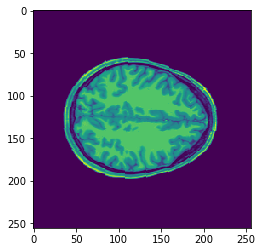

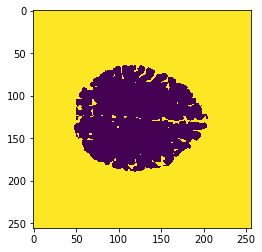

In [15]:
j = 4
plt.imshow(inputs['x'][j,0,:,:].numpy())
plt.show()
plt.imshow(inputs['y'][j,0,:,:].numpy())
plt.show()

In [29]:
def visualize_tissue(list_segs):
    inputs = next(iter(dataloader['train']))
    for j in range(18):
        imgs_masked = [0]*44
        inp_img = inputs['y'][j,:,:,:].numpy()
        for i in list_segs:
            imgs_masked[i] = np.ma.masked_where(inp_img[i,:,:] == 0, inp_img[i,:,:])
    
    
        plt.figure(figsize=(20,10))
        plt.subplot(1,2,1)
        plt.imshow(inputs['x'][j,0,:,:].numpy(), 'gray', interpolation='none')

        plt.subplot(1,2,2)
        plt.imshow(inputs['x'][j,0,:,:].numpy(), 'gray', interpolation='none')

        for i in list_segs:
            if np.sum(imgs_masked[i]) != 0:
                plt.imshow(imgs_masked[i], 'coolwarm_r', interpolation='none', alpha=0.9)
        
        plt.show()

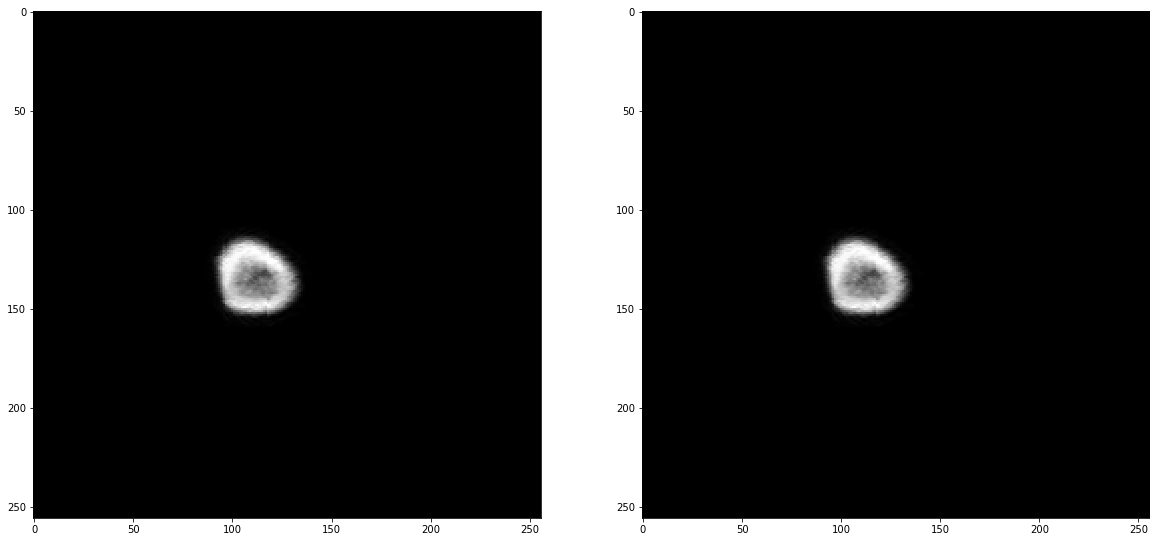

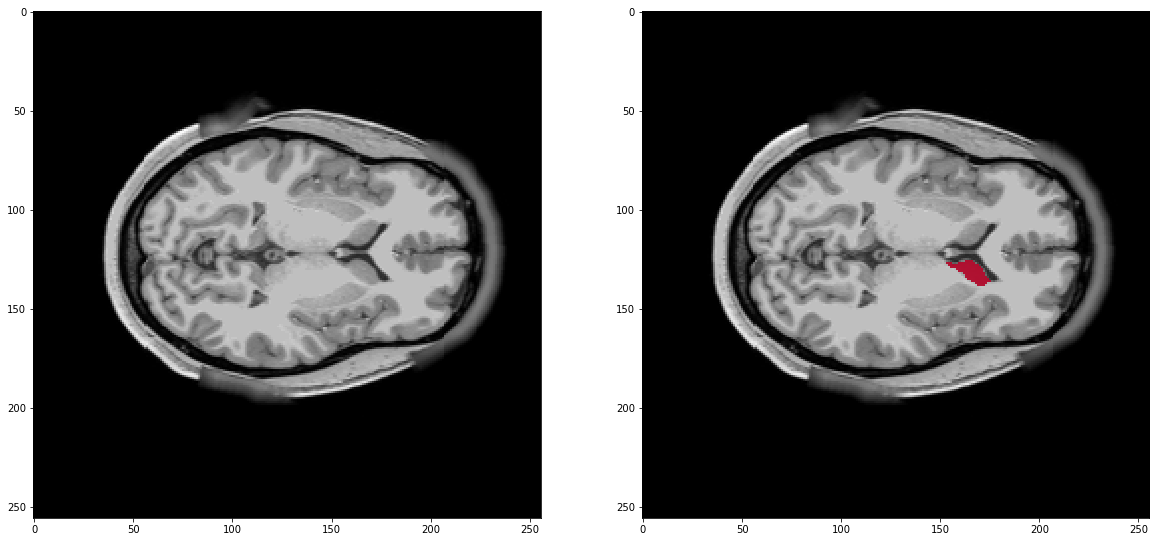

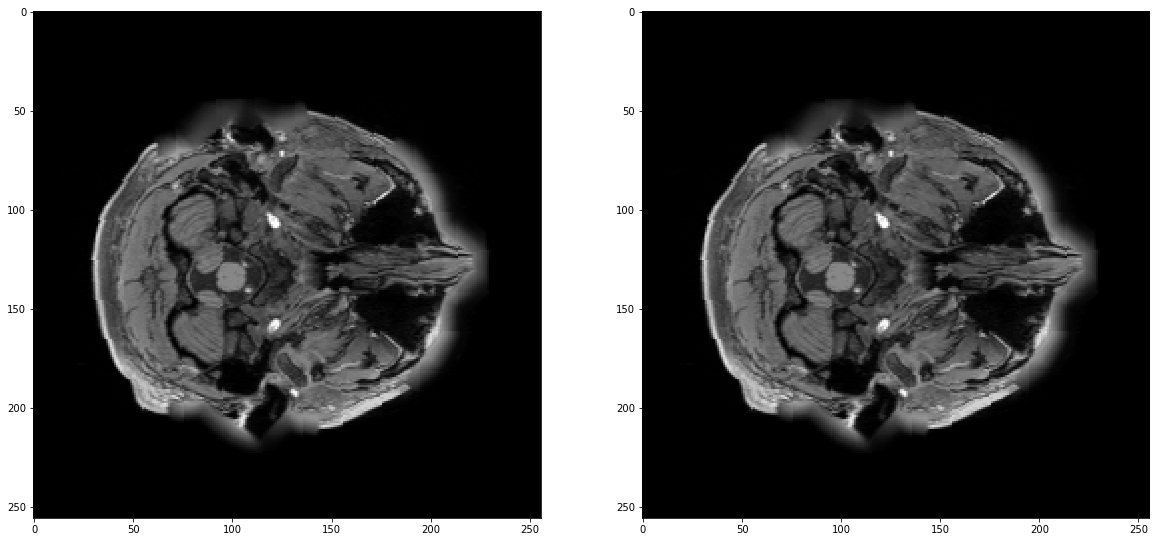

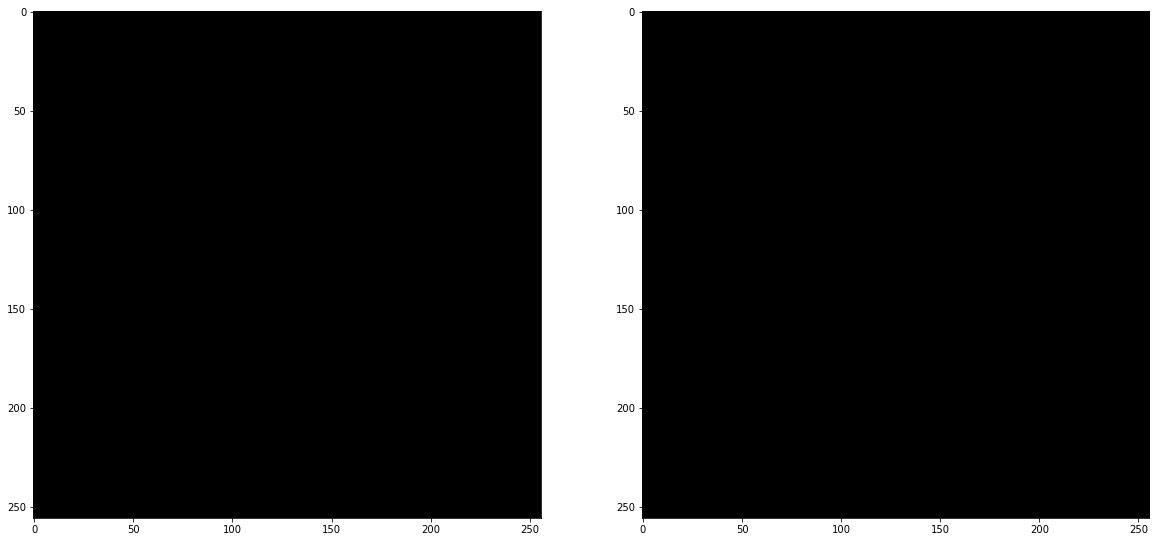

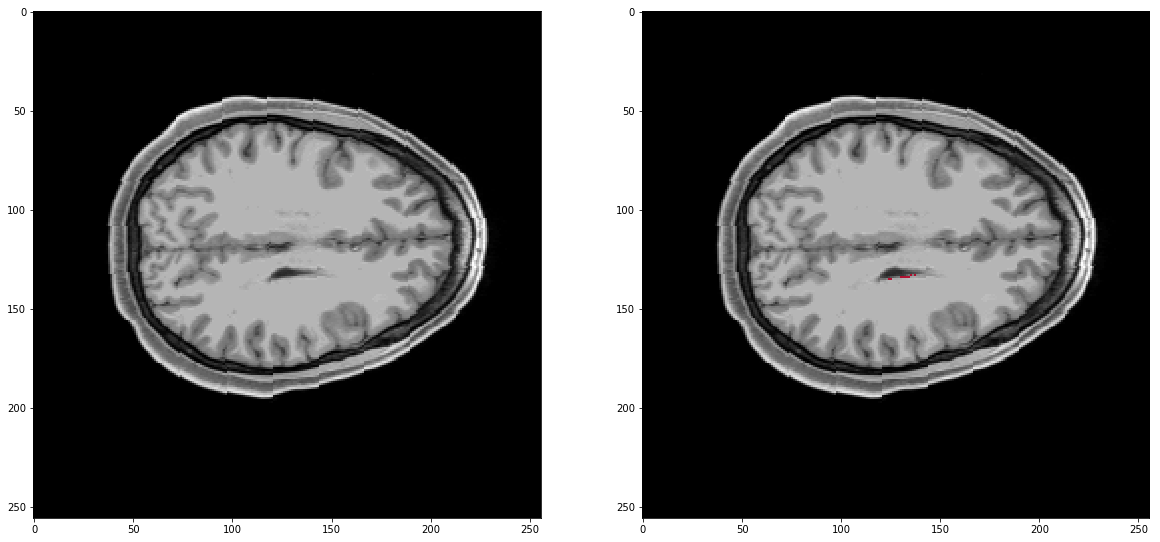

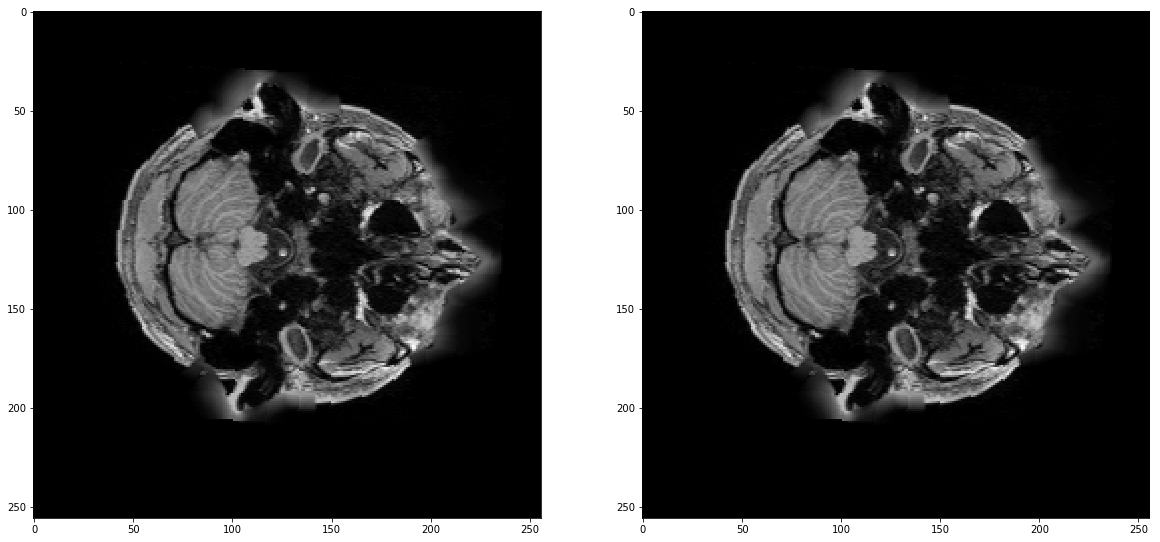

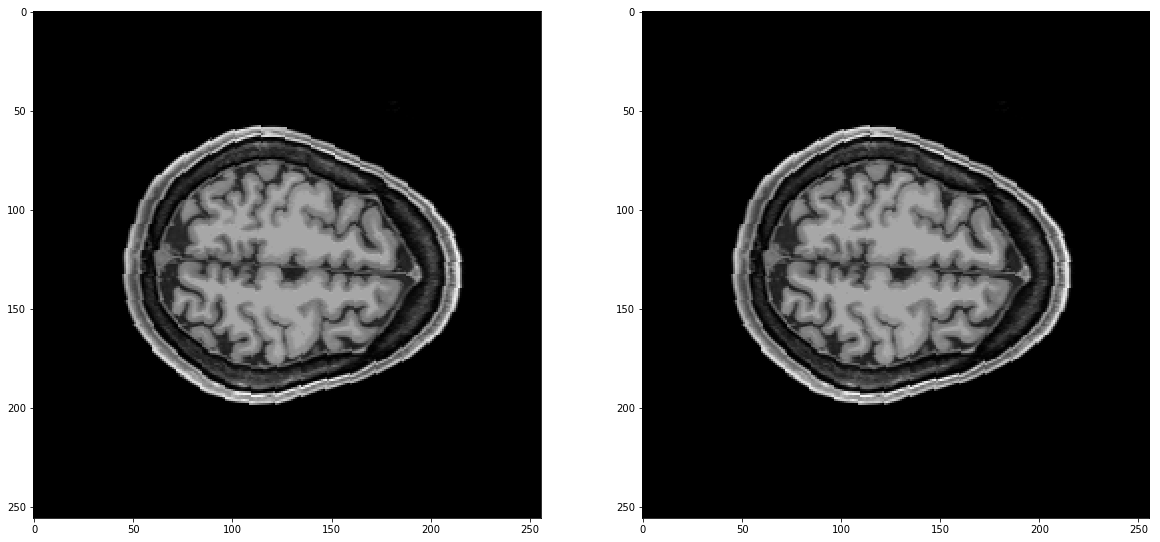

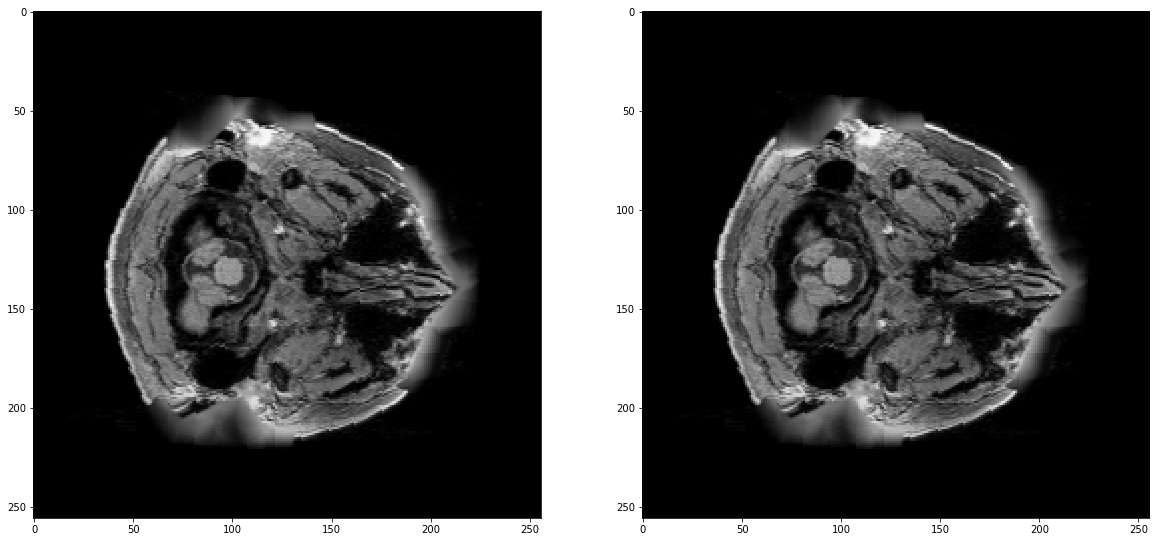

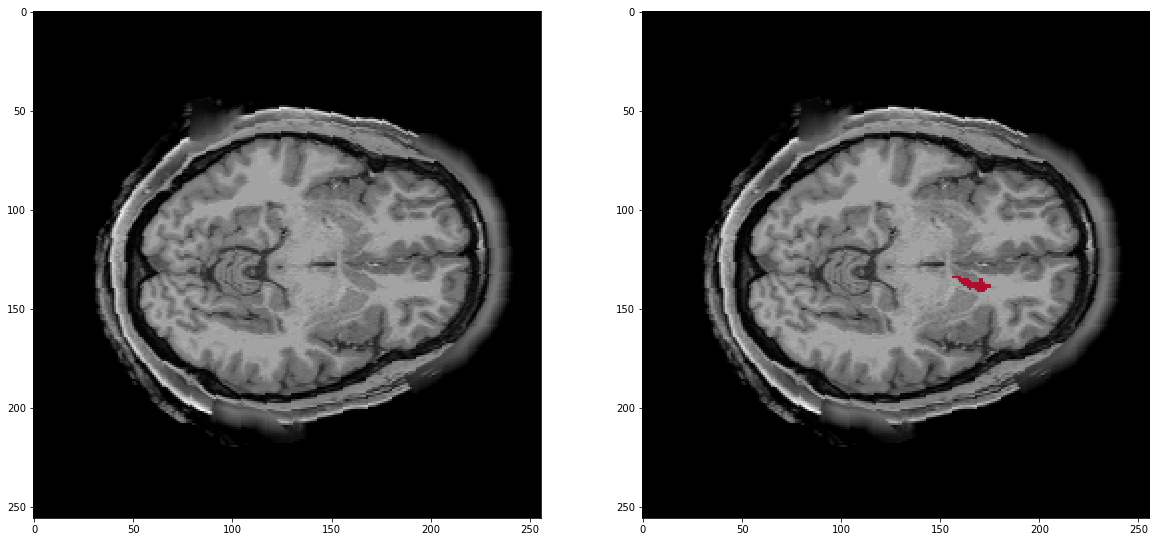

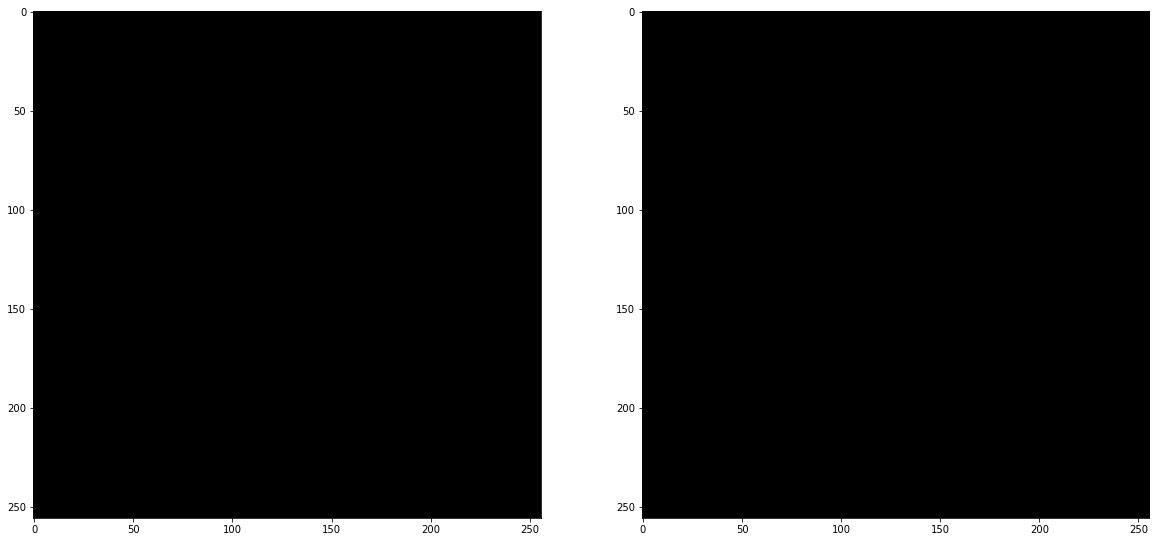

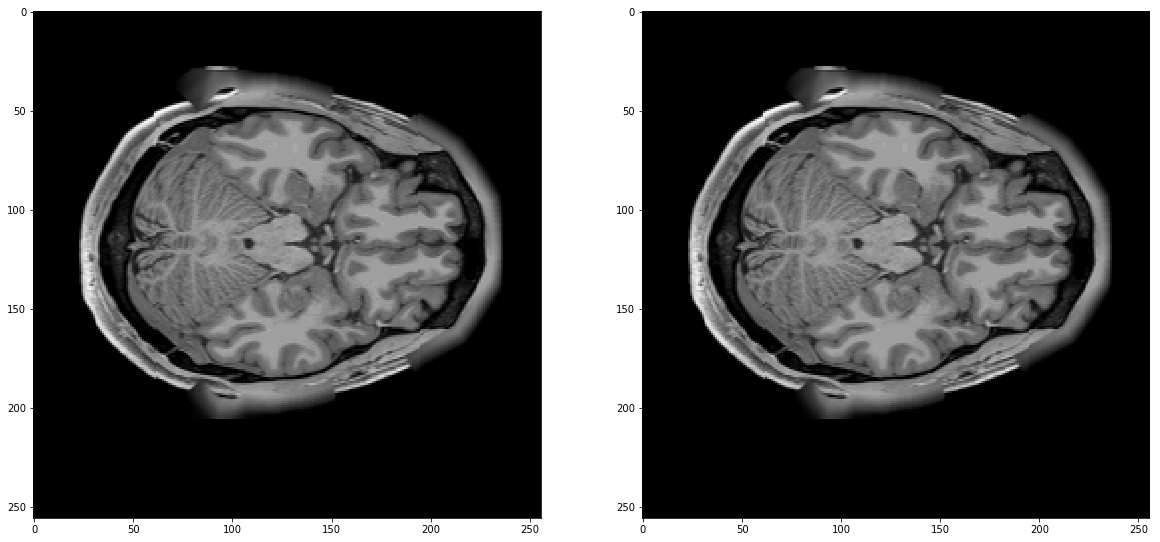

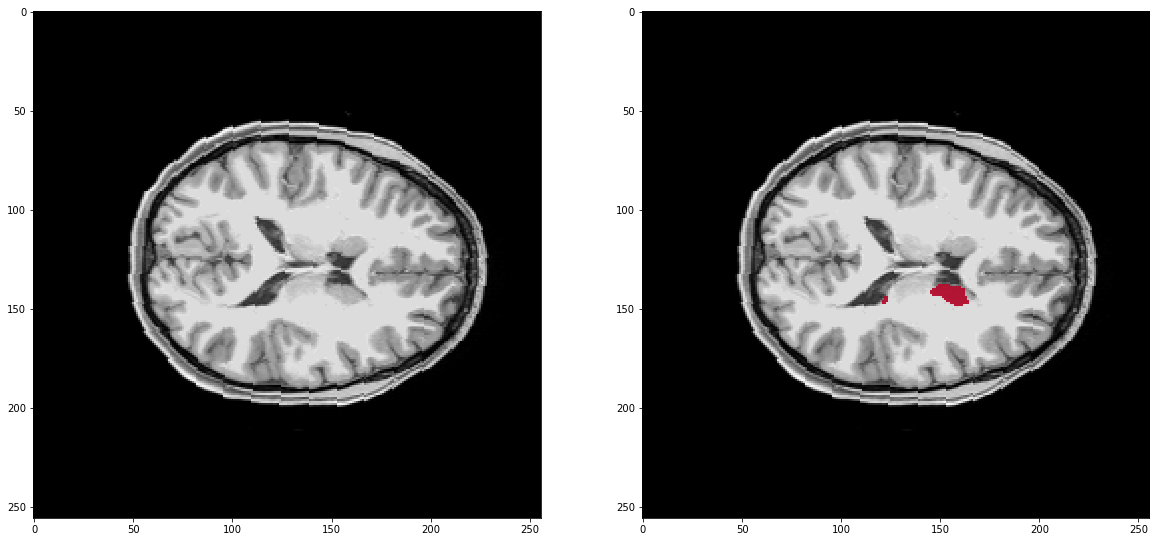

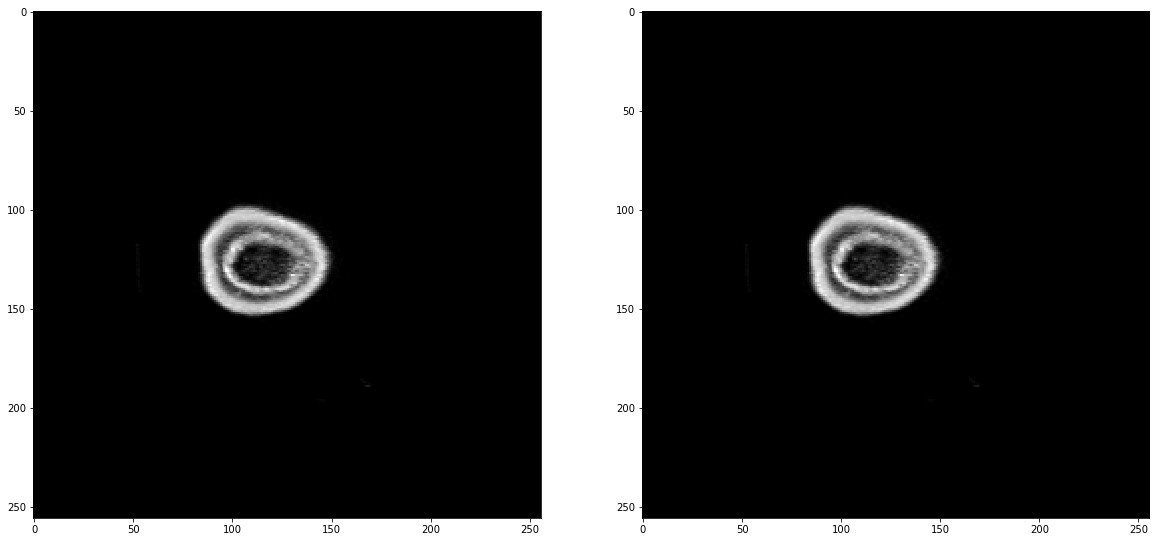

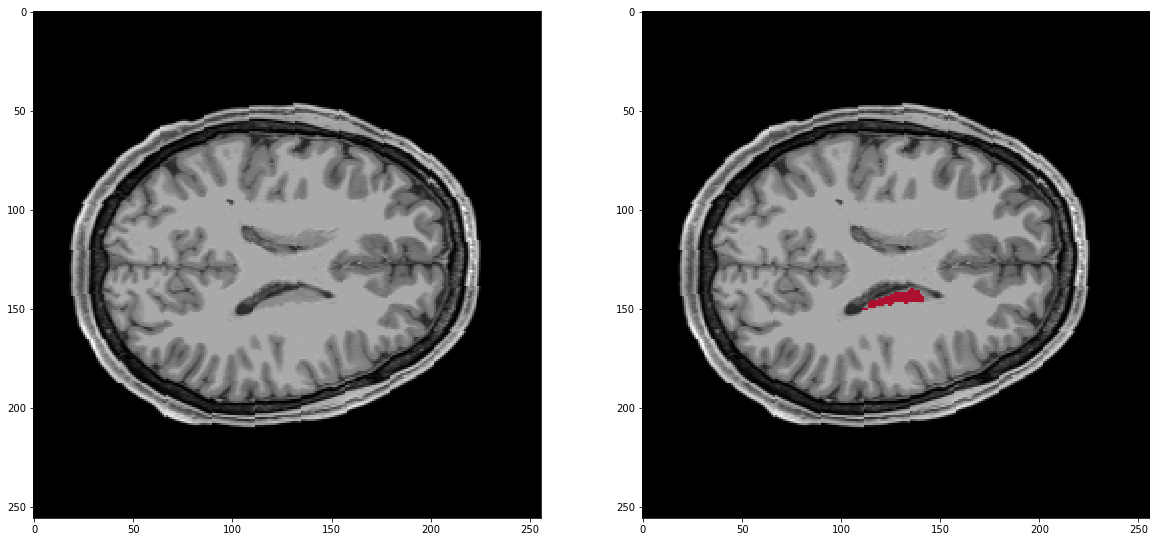

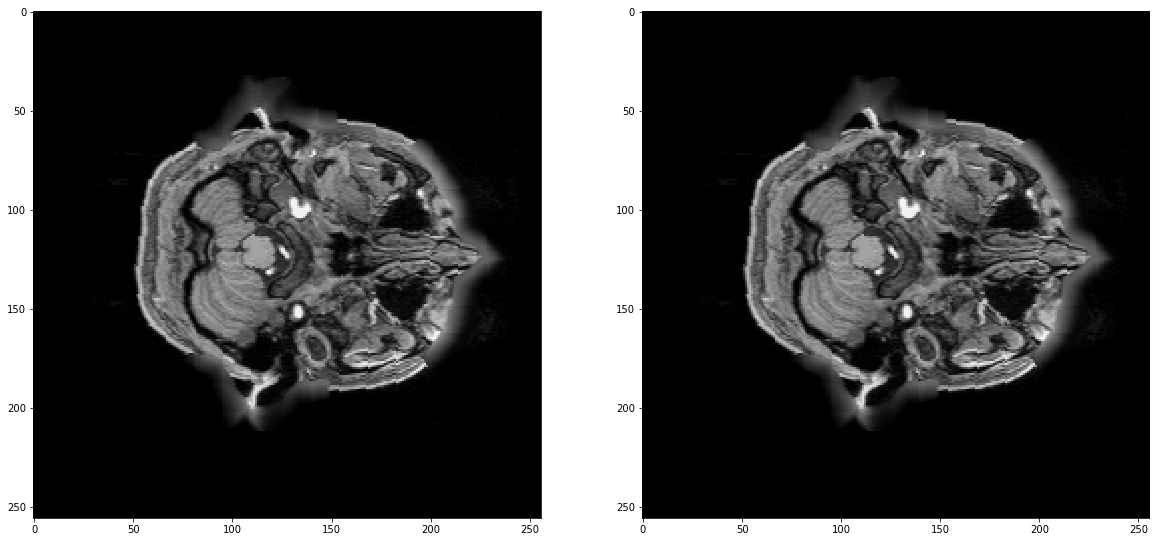

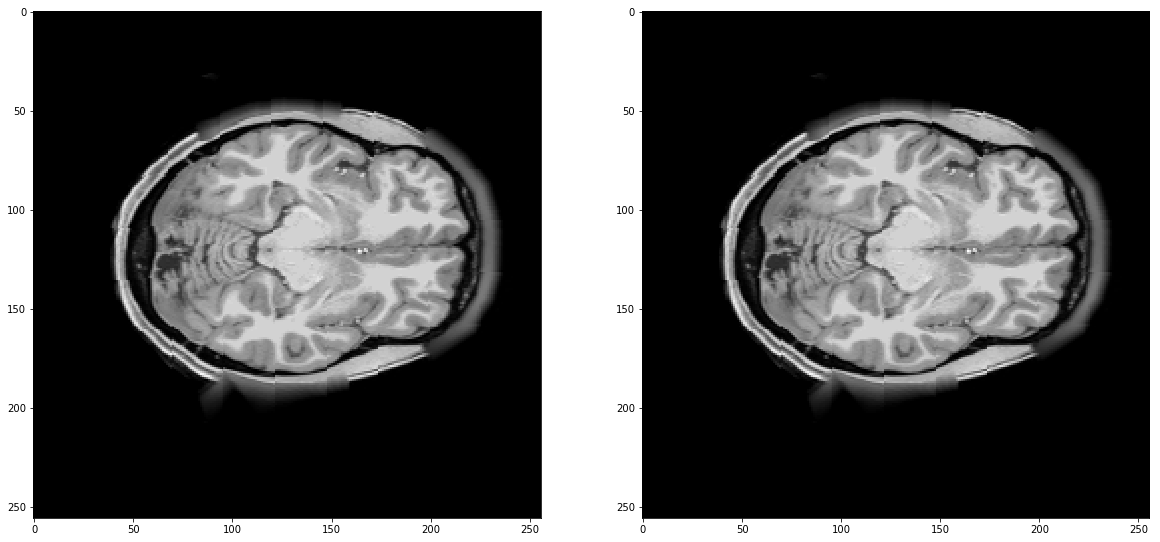

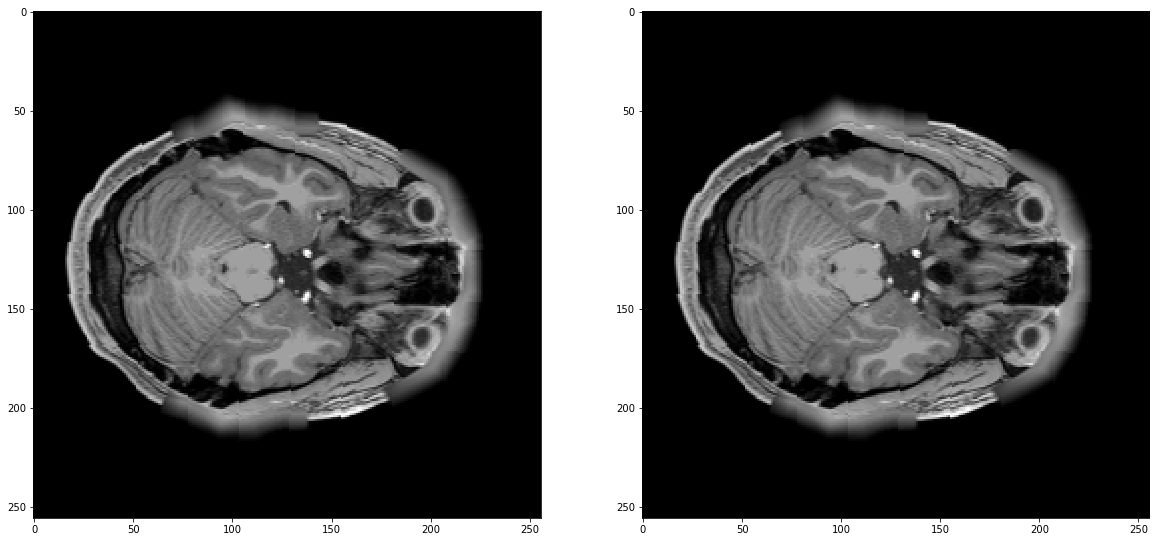

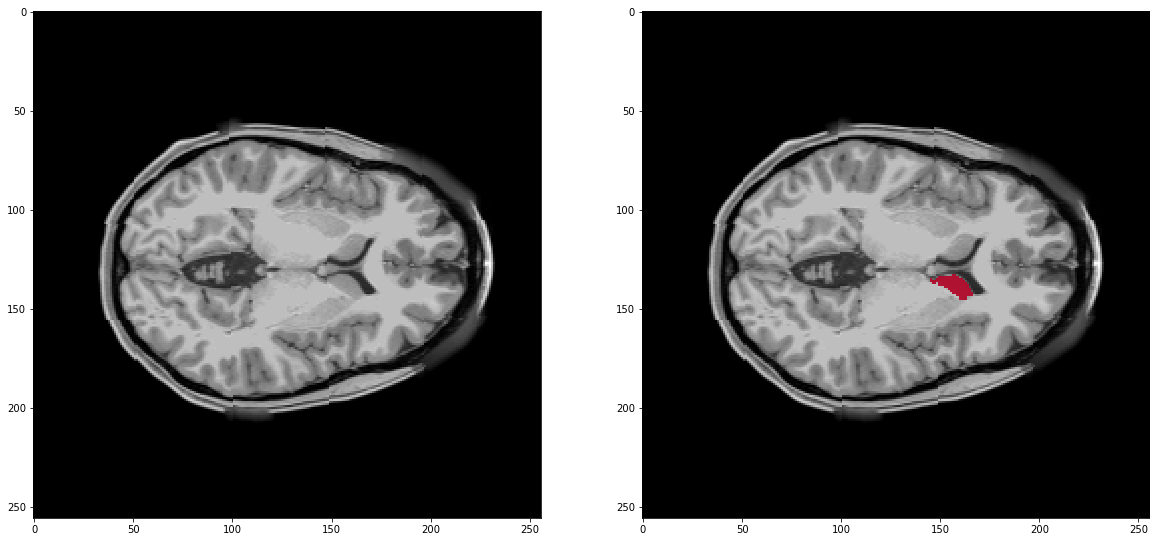

In [31]:
visualize_tissue([8])

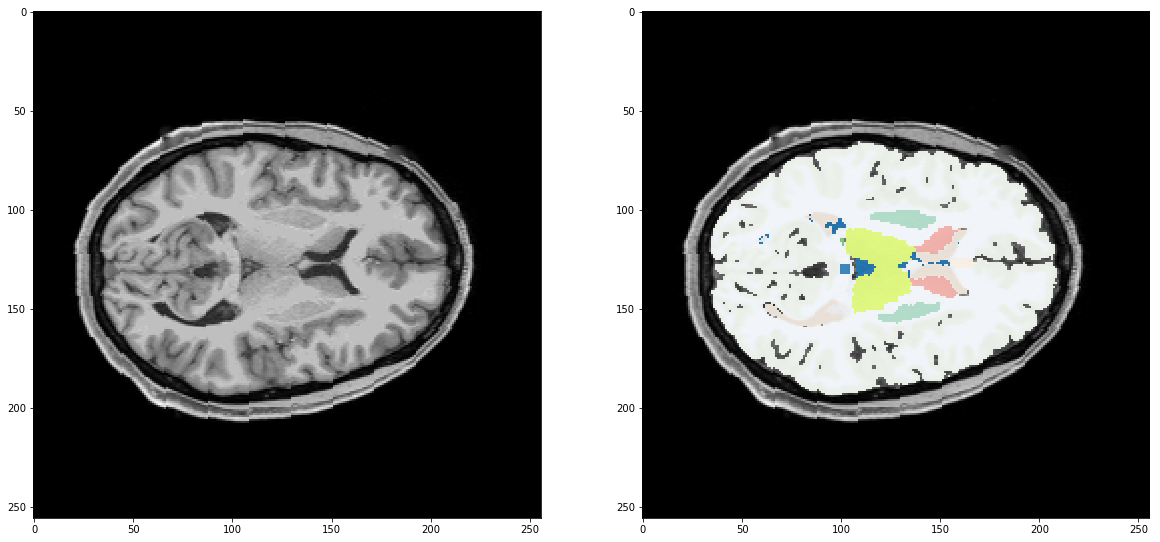

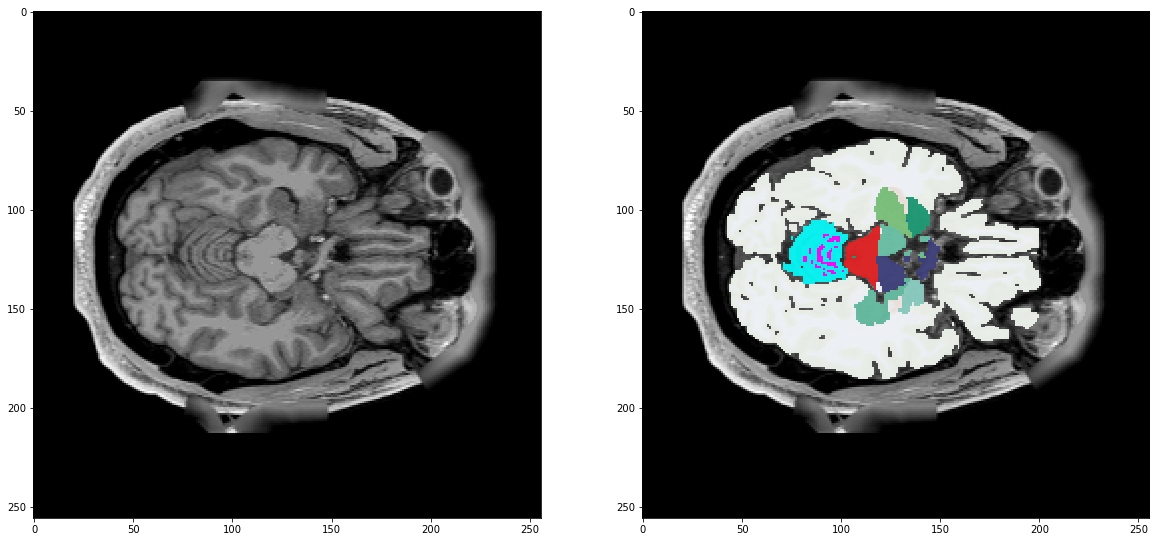

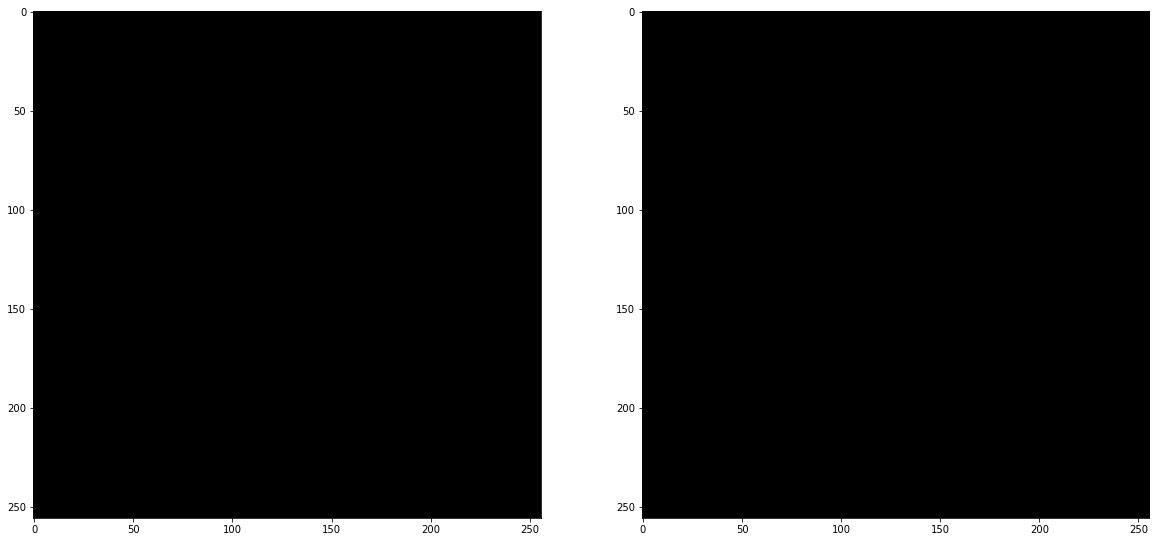

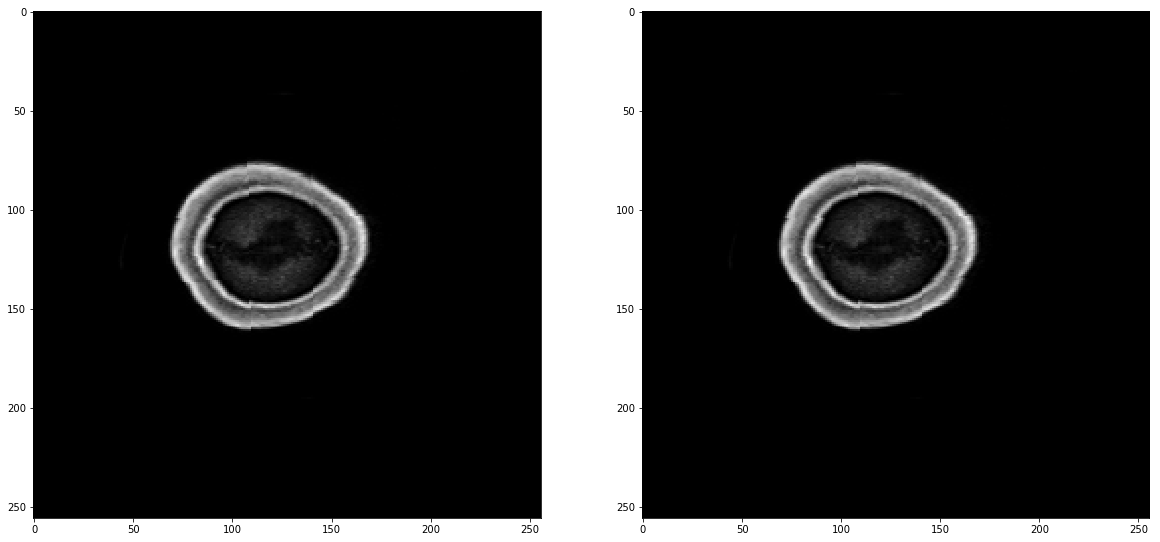

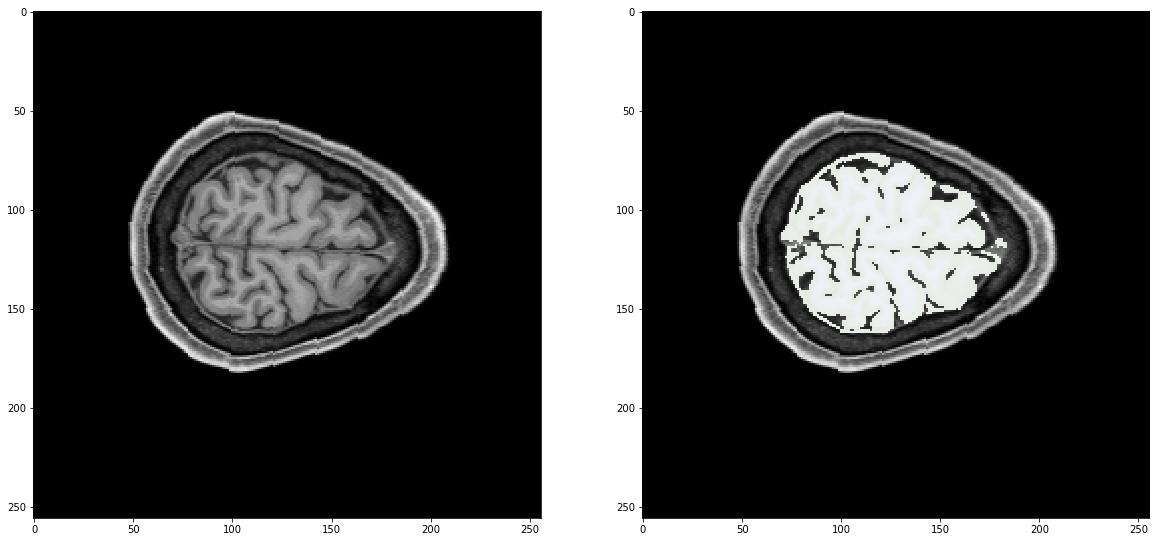

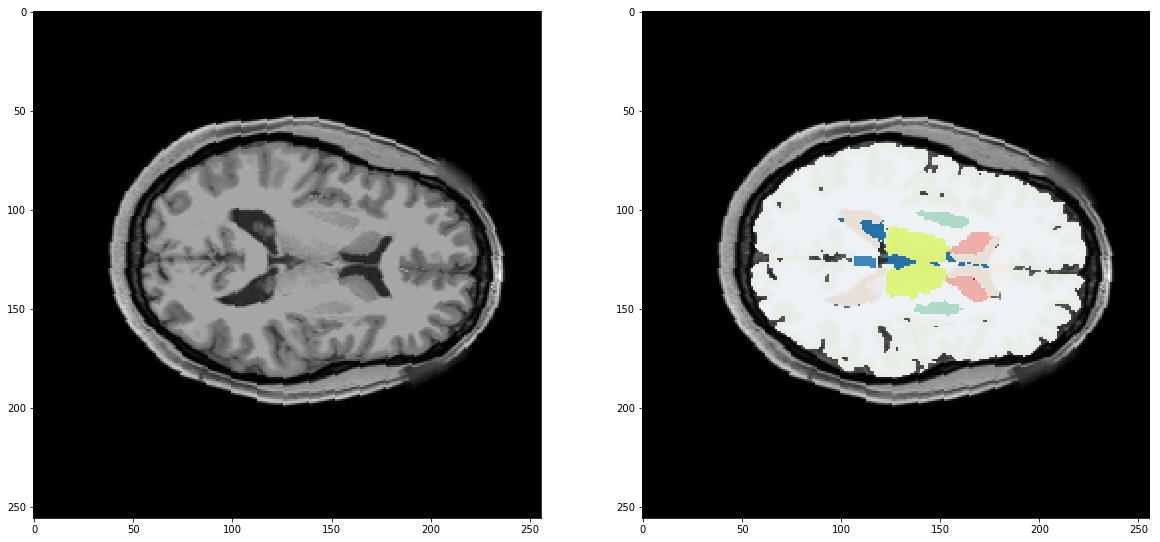

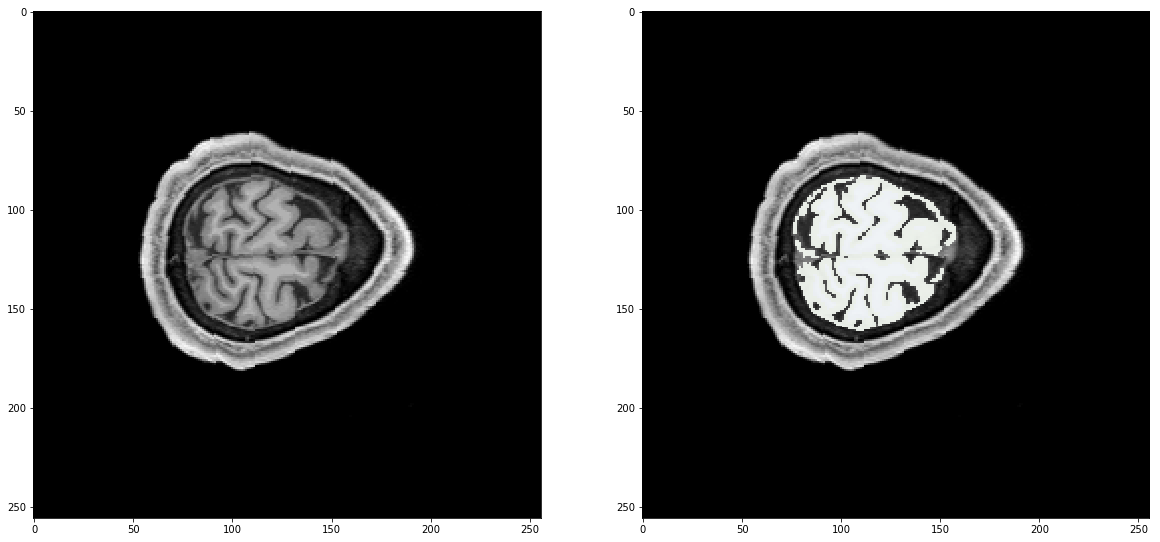

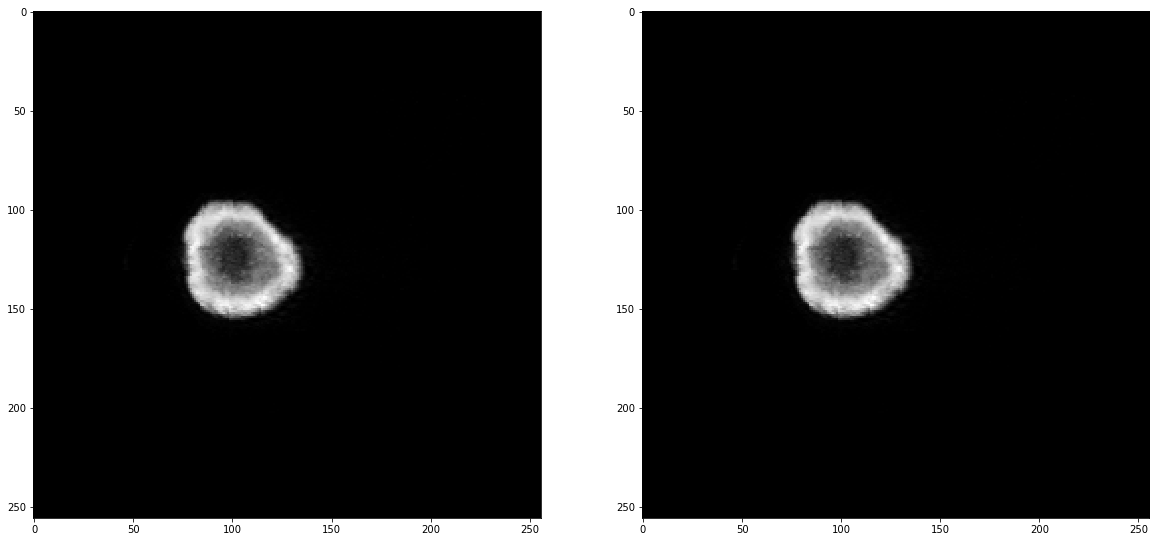

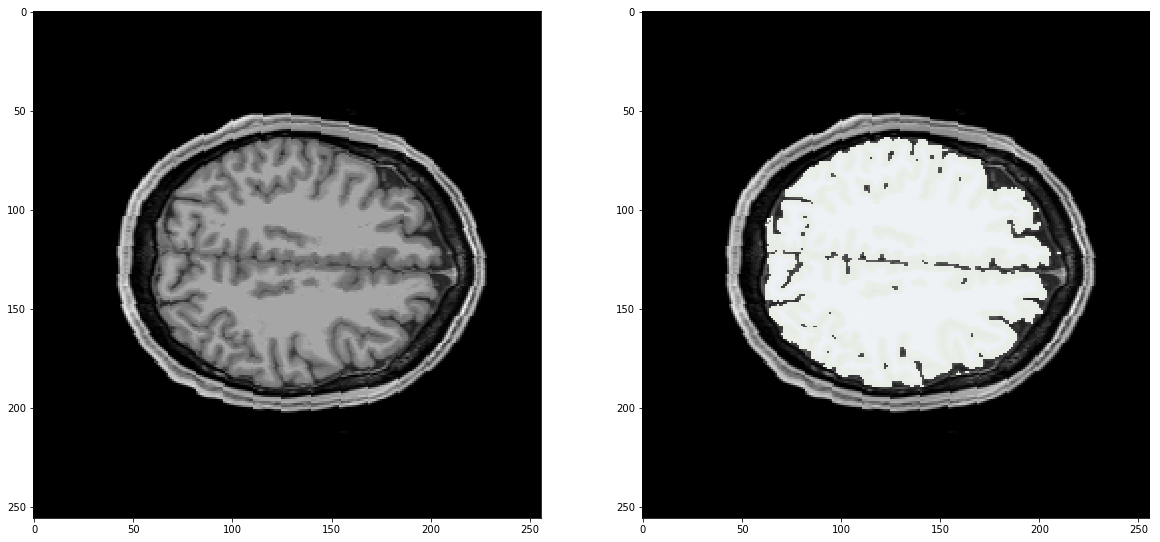

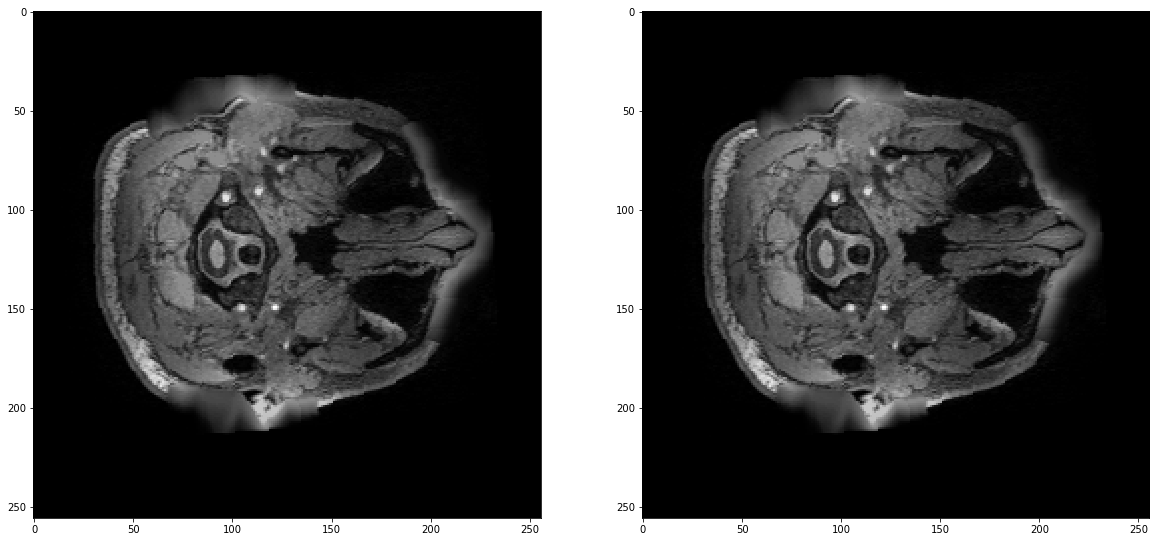

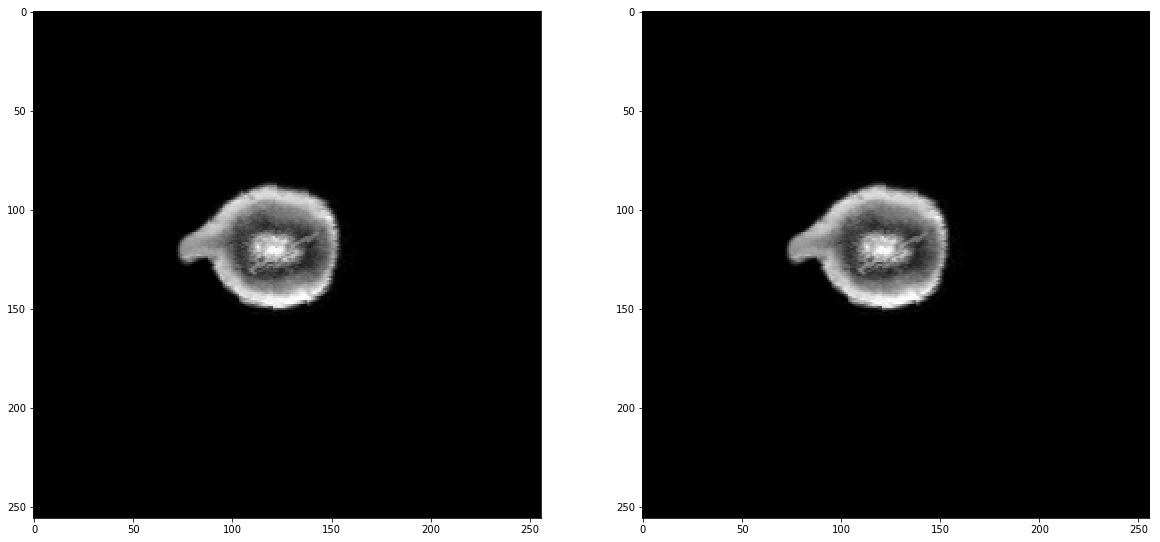

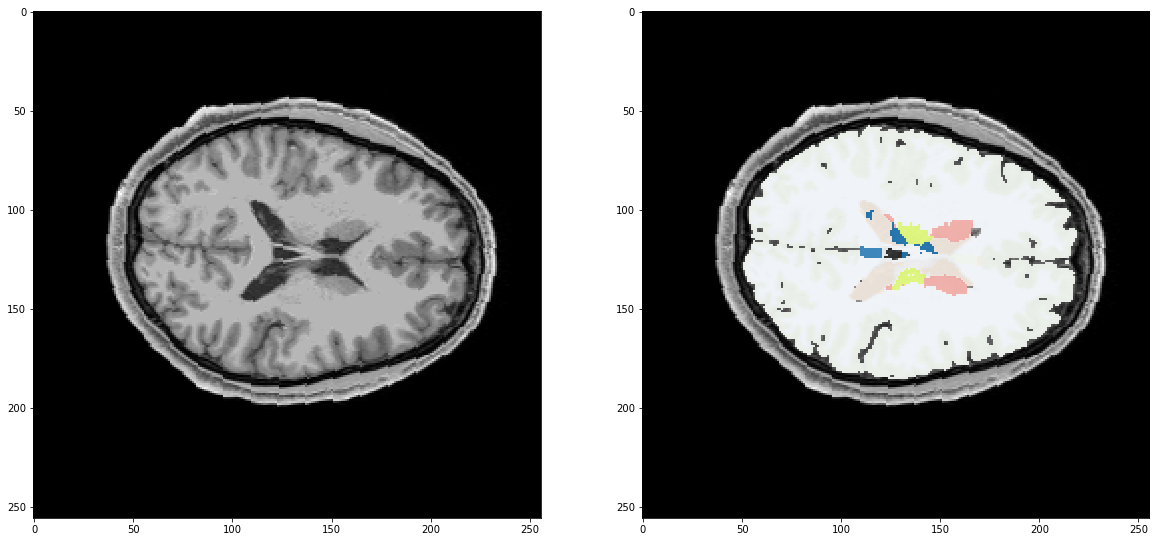

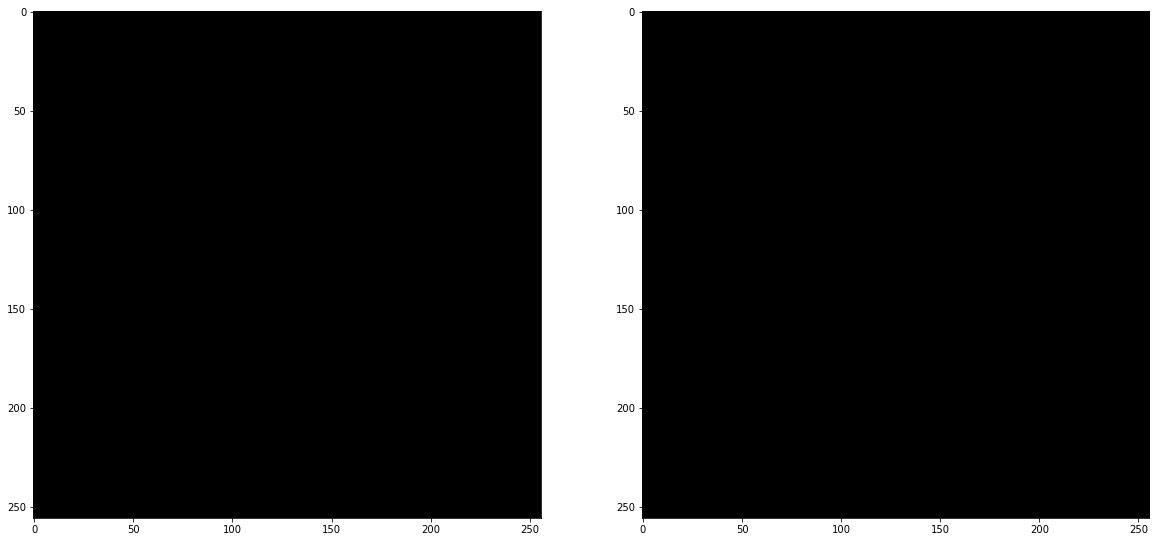

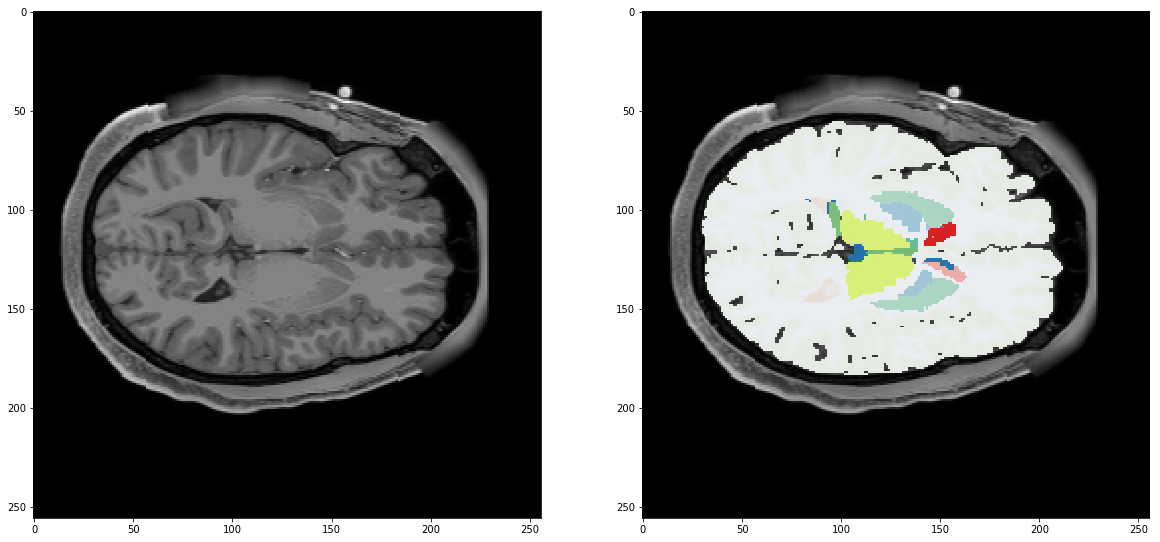

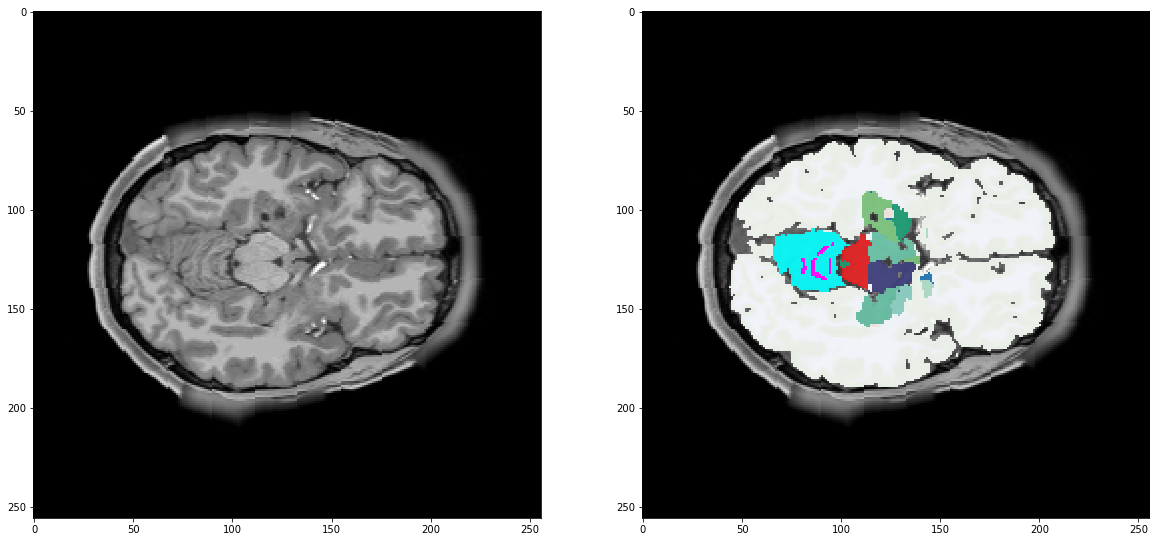

In [96]:
for j in range(15):
    #j = 4
    imgs_masked = [0]*44
    inp_img = inputs['y'][j,:,:,:].numpy()
    for i in range(1,44):
        imgs_masked[i] = np.ma.masked_where(inp_img[i,:,:] == 0, inp_img[i,:,:])
    
    
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.imshow(inputs['x'][j,0,:,:].numpy(), 'gray', interpolation='none')

    plt.subplot(1,2,2)
    plt.imshow(inputs['x'][j,0,:,:].numpy(), 'gray', interpolation='none')

    for i in range(1,44):
        if np.sum(imgs_masked[i]) != 0:
            plt.imshow(imgs_masked[i], colors[i], interpolation='none', alpha=0.9)
        
    plt.show()